In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from shared_decoding.utils.ibl_data_utils import seed_everything
from shared_decoding.utils.ibl_data_loaders import MultiSessionDataModule
from shared_decoding.models.neural_models import MultiSessionReducedRankDecoder, eval_multi_session_model
from shared_decoding.utils.hyperparam_tuning import tune_decoder

from ray import tune

seed_everything(0)

In [3]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['0a018f12-ee06-4b11-97aa-bbbff5448e9f', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '111c1762-7908-47e0-9f40-2f2ee55b6505', '09b2c4d1-058d-4c84-9fd4-97530f85baf6']


In [20]:
DEVICE = torch.device('cpu')

base_config = {
    'data_dir': data_dir,
    'temporal_rank': tune.grid_search([5, 15]),
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'imposter_id': None,
    'target': 'wheel_speed',
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': 4
}

configs = []
for eid in eids:
    config = base_config.copy()
    config['eid'] = eid
    configs.append(config)

##### Train Multi-Session Reduced Rank Decoder

In [5]:
def train_func(configs):
    dm = MultiSessionDataModule(eids, configs)
    dm.setup()
    base_config = dm.configs[0].copy()
    base_config['n_units'] = [config['n_units'] for config in dm.configs]
    model = MultiSessionReducedRankDecoder(base_config)

    trainer = Trainer(
        max_epochs=50,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [ ]:
results = tune_decoder(train_func, configs, use_gpu=False, max_epochs=50, num_samples=1, num_workers=2)

In [26]:
best_result = results.get_best_result(metric="val_loss", mode="min")
best_config = best_result.config['train_loop_config']
best_config 

In [27]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()
wandb_config = {}
wandb_config['save_dir'] = '../logs'
wandb_config['project'] = 'decoding'
wandb_config['runname'] = 'multi_sess'
wandb_logger = WandbLogger(
    log_model="all", save_dir=wandb_config['save_dir'], 
    project=wandb_config['project'], name=wandb_config['runname'],
)

In [ ]:
model_path = base_dir / 'models'
os.makedirs(model_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', mode='min', dirpath=model_path
)

trainer = Trainer(
    max_epochs=500, 
    callbacks=[checkpoint_callback], 
    enable_progress_bar=True,
    logger=wandb_logger
)
dm = MultiSessionDataModule(eids, best_config)
dm.setup()
best_config = dm.configs[0].copy()
best_config['n_units'] = [config['n_units'] for config in dm.configs]
model = MultiSessionReducedRankDecoder(best_config)

trainer.fit(model, datamodule=dm)
trainer.test(datamodule=dm, ckpt_path='best')

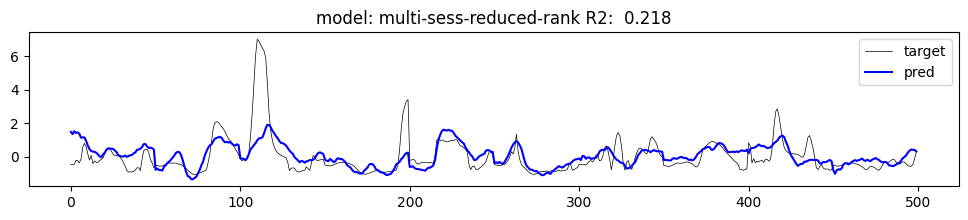

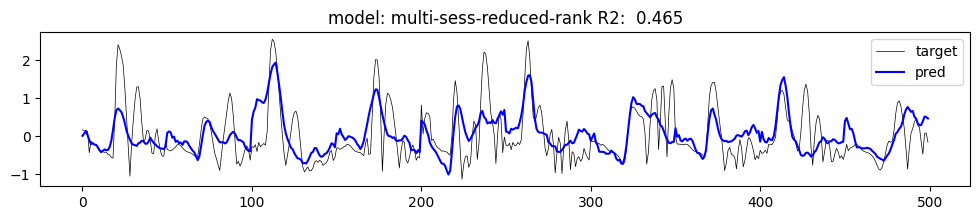

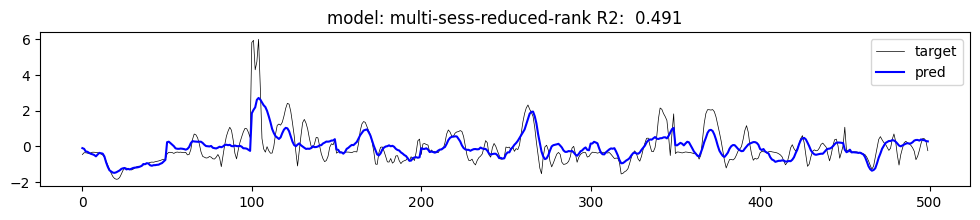

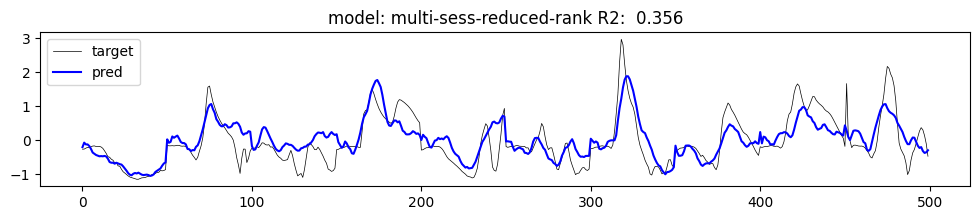

In [30]:
r2_lst, test_pred_lst, test_y_lst = eval_multi_session_model(dm.train, dm.test, model, plot=True)

In [ ]:
wandb.finish()

#### Train Linear Decoder

In [38]:
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

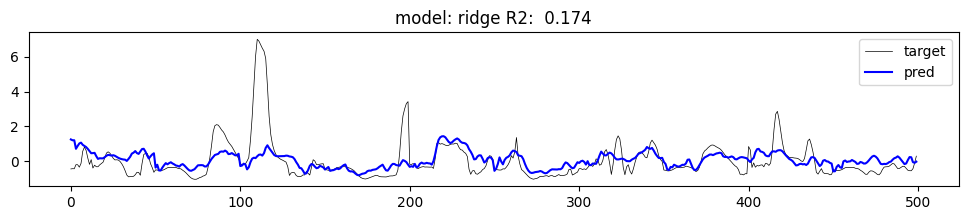

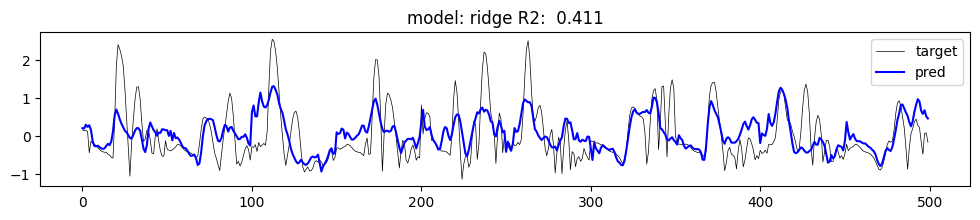

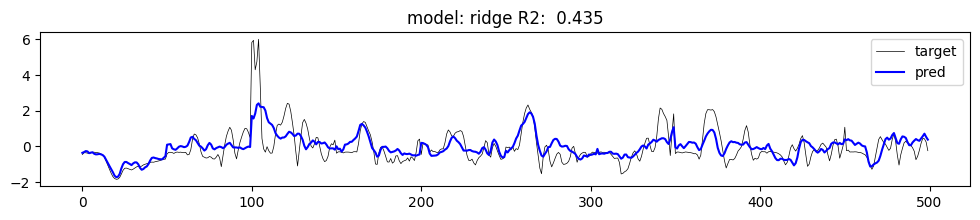

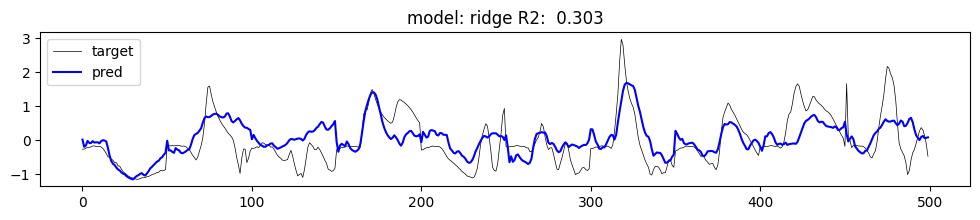

In [39]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})
for eid_idx in range(len(eids)):
    r2, test_pred, test_y = eval_model(
        dm.train[eid_idx], dm.test[eid_idx], model, model_type="ridge", training_type='multi-sess', plot=True
    )